<img style="float: left; margin: 30px 15px 15px 15px;" src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png" width="300" height="500" /> 
    
    
### <font color='navy'> Simulación de procesos financieros. 

**Nombres:** Diego Alberto López Lazareno, Andrea Flores Fernández.

**Fecha:** 24 de noviembre del 2021.

**Expediente** : 722100, 725449.
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: https://github.com/diegolazareno/Tarea9_DALopez_AFlores

# Tarea 9: Clase 23

## Enunciado de tarea 

Implementar el método de esquemas del trapecio, para valuar la opción call y put asiática con precio inicial, $S_0 = 100$, precio de ejercicio $K = 100$, tasa libre de riesgo $r = 0.10$, volatilidad $\sigma = 0.20$ y $T = 1$ año. Cuyo precio es $\approx 7.04$. Realizar la simulación en base a la siguiente tabla:

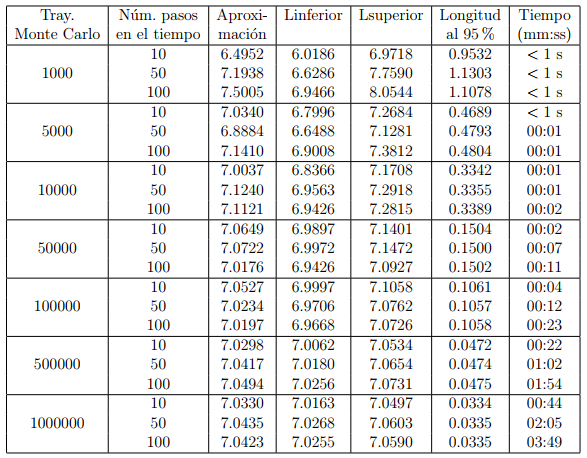

Observe que en esta tabla se encuentran los intervalos de confianza de la aproximación obtenida y además el tiempo de simulación que tarda en encontrar la respuesta cada método. 
- Se debe entonces realizar una simulación para la misma cantidad de trayectorias y número de pasos y construir una Dataframe de pandas para reportar todos los resultados obtenidos.**(70 puntos)**
- Compare los resultados obtenidos con los resultados arrojados por la función `Riemann_approach`. Concluya. **(30 puntos)**

### Ejercicio 1

`Estudiante 1 : Diego`

In [1]:
# Librerías necesarias
import pandas as pd
import numpy as np
import datetime
import scipy.stats as st

# Funciones
def priceSimulations(mu, sigma, S0, trajectories, steps):
    """
    priceSimulations retorna St, una matriz con la simulación de precios para un activo financiero.
    
    *mu : es la tasa libre de riesgo (anualizada).
    *sigma : es la volatilidad del subyacente (anualizada).
    *S0 : es el precio inicial del subyacente.
    *trajectories : es el número de trayectorias a simular.
    *steps : es el número de pasos o días a simular.
    
    """
    deltaT = 1 / steps
    increments = (mu - sigma ** 2 / 2) * deltaT + sigma * np.random.randn(steps - 1, trajectories) * np.sqrt(deltaT) 
    St = np.exp(np.concatenate([np.log(S0) * np.ones([1, trajectories]), increments], axis = 0).cumsum(axis = 0))
    
    return pd.DataFrame(St)

def RiemannSums(mu, sigma, S0, trajectories, steps, K, optionType):
    """
    RiemannSums valúa una opción del tipo euroasiática por el método de las sumas de Riemann.
    
    *mu : es la tasa libre de riesgo (anualizada).
    *sigma : es la volatilidad del subyacente (anualizada).
    *S0 : es el precio inicial del subyacente.
    *trajectories : es el número de trayectorias a simular.
    *steps : es el número de pasos o días a simular.
    *K : es el precio de ejercicio.
    *optionType : es el tipo de opción a valuar, Call o Put.
    
    """
    t0 = datetime.datetime.now()
    St = priceSimulations(mu, sigma, S0, trajectories, steps)
    average_St = St.expanding().mean()
    
    # Valuación Call
    if optionType == "Call":
        optionPrice = np.exp(-mu) * np.fmax(average_St - K, 0).mean(axis = 1)
        
    # Valuación Put
    else:
        optionPrice = np.exp(-mu) * np.fmax(K - average_St, 0).mean(axis = 1)
    
    confidenceInterval = st.norm.interval(0.95, loc = optionPrice.iloc[-1], scale = st.sem(optionPrice))
    
    t1 = datetime.datetime.now() - t0
    if t1.seconds < 1:
        t1 = str("<1s")
    else:
        t1 = str(t1)[2 : 7]

    
    return optionPrice.iloc[-1], confidenceInterval[0], confidenceInterval[1], confidenceInterval[1] - confidenceInterval[0], t1
    
def Trapezoid(mu, sigma, S0, trajectories, steps, K, optionType):
    """
    Trapezoid valúa una opción del tipo euroasiática por el esquema del trapecio.
    
    *mu : es la tasa libre de riesgo (anualizada).
    *sigma : es la volatilidad del subyacente (anualizada).
    *S0 : es el precio inicial del subyacente.
    *trajectories : es el número de trayectorias a simular.
    *steps : es el número de pasos o días a simular.
    *K : es el precio de ejercicio.
    *optionType : es el tipo de opción a valuar, Call o Put.
    
    """
    t0 = datetime.datetime.now()
    St = priceSimulations(mu, sigma, S0, trajectories, steps)
    average_St = ((St * (2 + mu * (1 / steps) + np.random.randn(steps, trajectories) * sigma)).cumsum()) * (1 / (2 * steps))
    
    # Valuación Call
    if optionType == "Call":
        optionPrice = np.exp(-mu) * np.fmax(average_St - K, 0).mean(axis = 1)
        
    # Valuación Put
    else:
        optionPrice = np.exp(-mu) * np.fmax(K - average_St, 0).mean(axis = 1)
    
    confidenceInterval = st.norm.interval(0.95, loc = optionPrice.iloc[-1], scale = st.sem(optionPrice))
    
    t1 = datetime.datetime.now() - t0
    if t1.seconds < 1:
        t1 = str("<1s")
    else:
        t1 = str(t1)[2 : 7]

    
    return optionPrice.iloc[-1], confidenceInterval[0], confidenceInterval[1], confidenceInterval[1] - confidenceInterval[0], t1
    

In [2]:
# Parámetros iniciales 
mu = 0.10 # Tasa libre de riesgo anualizada
sigma = 0.20 # Volatilidad anualizada
S0 = 100 # Precio inicial
K = 100 # Precio de ejercicio de la opción
NSteps = [10, 50, 100] # Número de pasos
Ntrajectories = [1000, 5000, 10000, 50000, 100000, 500000, 1000000] # Número de trayectorias
#Ntrajectories = [1000, 5000, 10000, 50000] # Número de trayectorias
index = pd.MultiIndex.from_product([Ntrajectories, NSteps], names = ["Tray. Monte Carlo", "Núm. pasos en el tiempo"]) # Índice
cols = ["Aproximación", "Linferior", "Lsuperior", "Longitud al 95%", "Tiempo (mm:ss)"] # Columnas

## Valuación por Sumas de Riemann

### Call 

In [3]:
results1 = []
[[results1.append(RiemannSums(mu, sigma, S0, j, i, K, "Call")) for i in NSteps] for j in Ntrajectories];
callRiemann = pd.DataFrame(results1, index = index, columns = cols)
callRiemann

Aproximación  Linferior  Lsuperior  \
Tray. Monte Carlo Núm. pasos en el tiempo                                       
1000              10                           6.079547   4.887329   7.271765   
                  50                           6.516940   6.036817   6.997063   
                  100                          6.622192   6.280245   6.964138   
5000              10                           6.215614   4.988444   7.442783   
                  50                           6.961739   6.442117   7.481362   
                  100                          6.874477   6.521269   7.227685   
10000             10                           6.524019   5.226874   7.821163   
                  50                           6.842282   6.330211   7.354353   
                  100                          6.964384   6.606763   7.322005   
50000             10                           6.437651   5.161385   7.713917   
                  50                           6.893617   6.379159   7.408074   
                  100                          7.009769   6.647529   7.372009   

                                           Longitud al 95% Tiempo (mm:ss)  
Tray. Monte Carlo Núm. pasos en el tiempo                                  
1000              10                              2.384436            <1s  
                  50                              0.960246            <1s  
                  100                             0.683893            <1s  
5000              10                              2.454339          00:01  
                  50                              1.039246          00:01  
                  100                             0.706416          00:01  
10000             10                              2.594289          00:02  
                  50                              1.024142          00:03  
                  100                             0.715242          00:03  
50000             10                              2.552532          00:16  
                  50                              1.028915          00:17  
                  100                             0.724480          00:19

### Put

In [4]:
results2 = []
[[results2.append(RiemannSums(mu, sigma, S0, j, i, K, "Put")) for i in NSteps] for j in Ntrajectories];
putRiemann = pd.DataFrame(results2, index = index, columns = cols)
putRiemann

Aproximación  Linferior  Lsuperior  \
Tray. Monte Carlo Núm. pasos en el tiempo                                       
1000              10                           2.080826   1.687707   2.473945   
                  50                           2.336936   2.193027   2.480846   
                  100                          2.465773   2.359543   2.572003   
5000              10                           2.259947   1.828625   2.691268   
                  50                           2.422603   2.269083   2.576123   
                  100                          2.489894   2.382519   2.597270   
10000             10                           2.254111   1.822595   2.685627   
                  50                           2.313915   2.166402   2.461428   
                  100                          2.340382   2.240293   2.440472   
50000             10                           2.208983   1.784802   2.633164   
                  50                           2.366785   2.215274   2.518295   
                  100                          2.313041   2.215236   2.410846   

                                           Longitud al 95% Tiempo (mm:ss)  
Tray. Monte Carlo Núm. pasos en el tiempo                                  
1000              10                              0.786238            <1s  
                  50                              0.287819            <1s  
                  100                             0.212460            <1s  
5000              10                              0.862643          00:01  
                  50                              0.307039          00:01  
                  100                             0.214750          00:02  
10000             10                              0.863032          00:04  
                  50                              0.295025          00:04  
                  100                             0.200180          00:03  
50000             10                              0.848361          00:21  
                  50                              0.303021          00:18  
                  100                             0.195610          00:20

## Valuación por Esquema del Trapecio

### Call

In [5]:
results3 = []
[[results3.append(Trapezoid(mu, sigma, S0, j, i, K, "Call")) for i in NSteps] for j in Ntrajectories];
callTrapezoid = pd.DataFrame(results3, index = index, columns = cols)
callTrapezoid

Aproximación  Linferior  Lsuperior  \
Tray. Monte Carlo Núm. pasos en el tiempo                                       
1000              10                           6.477008   5.206634   7.747382   
                  50                           7.200805   6.773737   7.627873   
                  100                          6.869210   6.600620   7.137800   
5000              10                           6.884790   5.534752   8.234827   
                  50                           7.022910   6.606245   7.439575   
                  100                          6.997182   6.721632   7.272733   
10000             10                           6.910087   5.554892   8.265281   
                  50                           6.976231   6.563109   7.389353   
                  100                          6.949477   6.676819   7.222134   
50000             10                           6.998855   5.625959   8.371750   
                  50                           7.008790   6.594710   7.422869   
                  100                          7.065169   6.787117   7.343221   

                                           Longitud al 95% Tiempo (mm:ss)  
Tray. Monte Carlo Núm. pasos en el tiempo                                  
1000              10                              2.540748            <1s  
                  50                              0.854136            <1s  
                  100                             0.537181            <1s  
5000              10                              2.700075          00:03  
                  50                              0.833330          00:03  
                  100                             0.551102          00:04  
10000             10                              2.710389          00:06  
                  50                              0.826245          00:06  
                  100                             0.545315          00:06  
50000             10                              2.745791          00:31  
                  50                              0.828159          00:32  
                  100                             0.556104          00:30

### Put

In [6]:
results4 = []
[[results4.append(Trapezoid(mu, sigma, S0, j, i, K, "Put")) for i in NSteps] for j in Ntrajectories];
putTrapezoid = pd.DataFrame(results4, index = index, columns = cols)
putTrapezoid

Aproximación  Linferior  Lsuperior  \
Tray. Monte Carlo Núm. pasos en el tiempo                                       
1000              10                           2.339922 -14.738232  19.418076   
                  50                           2.318909  -5.149417   9.787234   
                  100                          2.493186  -2.751869   7.738240   
5000              10                           2.195259 -14.924884  19.315401   
                  50                           2.347672  -5.110182   9.805525   
                  100                          2.317250  -2.943522   7.578022   
10000             10                           2.160148 -14.970224  19.290520   
                  50                           2.274260  -5.199038   9.747559   
                  100                          2.370276  -2.888792   7.629344   
50000             10                           2.219110 -14.901761  19.339981   
                  50                           2.313154  -5.150992   9.777300   
                  100                          2.325517  -2.933660   7.584693   

                                           Longitud al 95% Tiempo (mm:ss)  
Tray. Monte Carlo Núm. pasos en el tiempo                                  
1000              10                             34.156308            <1s  
                  50                             14.936652            <1s  
                  100                            10.490109            <1s  
5000              10                             34.240285          00:03  
                  50                             14.915707          00:03  
                  100                            10.521544          00:03  
10000             10                             34.260744          00:06  
                  50                             14.946597          00:05  
                  100                            10.518136          00:06  
50000             10                             34.241742          00:32  
                  50                             14.928292          00:32  
                  100                            10.518353          00:29

## Conclusión

`Estudiante 2 : Andrea`

In [1]:
#Importar las librerías necesarias:
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
%matplotlib inline
#Pandas
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 9)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)
# Datos escenario: 
np.random.seed(5555)
S0 = 100; K = 100 ; r = 0.10
sigma = 0.20; T = 1 ;p = 7.04
NbTraj = [1000, 5000, 10000, 50000, 100000, 500000, 1000000]
NbStep = [10, 50, 100]

In [5]:
#b&s:
def BSprices(mu,sigma,S0,NbTraj,NbStep):
    nu = (mu-(sigma**2)/2)
    DeltaT = 1/NbStep
    SqDeltaT = np.sqrt(DeltaT)
    DeltaW = SqDeltaT*np.random.randn(NbTraj,NbStep-1)
    increments = nu*DeltaT + sigma*DeltaW
    concat = np.concatenate((np.log(S0)*np.ones([NbTraj,1]),increments),axis=1)
    LogSt = np.cumsum(concat,axis=1)
    St = np.exp(LogSt)
    t = np.arange(0,NbStep)
    return St.T,t
#Daily ret:
def calc_daily_ret(closes):
    return np.log(closes/closes.shift(1)).iloc[1:]

In [7]:
#Método trapecio:
#Para put:
def trapecio_p(K,r,S0,NbTraj:'Número trayectorias',NbStep:'Cantidad de pasos a simular',sigma:'Volatilidad',T:'Tiempo de cierre del contrato en años',tipo:"put o call"=None):
    start = time.time()
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    prices = pd.DataFrame(St,index=t)
    strike = K
    h = T/NbStep
    formula = (2+r*h+np.random.randn(NbStep,NbTraj)*sigma)
    av1 = np.cumsum(prices*(formula))
    av2 = h/(2*T)
    Average_t = av1*av2
    strike = K
    #si es put:
    if tipo == "put":
        put_opt = pd.DataFrame({"Prima":np.exp(-r*T)*np.fmax(strike-Average_t,0).mean(axis=1)},index=t)
    else:
        put_opt = pd.DataFrame({"Prima":np.exp(-r*T)*np.fmax(Average_t-strike,0).mean(axis=1)},index=t)
    # intervalos de confianza
    confianza = 0.95
    sigma_est = put_opt.sem().Prima
    mean_est = put_opt.iloc[-1].Prima
    i1 = st.norm.interval(confianza,loc=mean_est,scale=sigma_est)
    distance = (i1[1]-i1[0])
    distance2 = np.round(distance,4)
    end = time.time()
    time_dif = int(end-start)
    timef = '{:02d}:{:02d}'.format((time_dif%3600//60),time_dif%60)
    total_time = lambda x: '< 1 s'if x=='00:00' else x #también es para el formato
    il0=np.round(i1[0],4)
    il1=np.round(i1[1],4)
    res = np.array([np.round(put_opt.iloc[-1].Prima,4),il0,il1,distance2,total_time(timef)])
    return res

In [8]:
#Mapeo put trapecio: 
NbTraj = [1000, 5000, 10000, 50000, 100000, 500000, 1000000]
NbStep = [10, 50, 100]
trap_p =  np.array(list(map(lambda N_traj:list(map(lambda N_step:trapecio_p(K,r,S0,N_traj,N_step,sigma,T,"put"),NbStep)),NbTraj)))
num = (0, 1, 2)
pd.set_option("display.max_rows", None, "display.max_columns", None)
ciclo =[i for i in NbTraj for _ in num]
rs = np.array(list(map(lambda i: trap_p[:,:,i].flatten(),range(5))))
rs0 = np.round(rs[0].astype('float'),4)
rs1 = np.round(rs[1].astype('float'),4)
rs2 = np.round(rs[2].astype('float'),4)
rs3 = np.round(rs[3].astype('float'),4)
listas = [ciclo,(len(NbTraj)*NbStep),rs0,rs1,rs2,rs3,rs[4]]
index = pd.MultiIndex.from_arrays(listas,names=('Tray.Monte Carlo','Núm.Pasos en el tiempo','Aproximación','Linferior','Lsuperior','Longitud al 95%','Tiempo (mm::ss)'))
df_trapecio_p = pd.DataFrame(index=index)

In [9]:
#Para call:
def trapecio_c(K,r,S0,NbTraj:'Número trayectorias',NbStep:'Cantidad de pasos a simular',sigma:'Volatilidad',T:'Tiempo de cierre del contrato en años',tipo:"put o call"=None):
    start = time.time()
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    prices = pd.DataFrame(St,index=t)
    strike = K
    h = (T/NbStep)
    formula = (2+r*h+np.random.randn(NbStep,NbTraj)*sigma)
    Av1 = np.cumsum(prices*(formula))
    Av2 = h/(2*T)
    Average_t = Av1*Av2
    strike = K
    #si es call:
    if tipo == "call":
        call_opt = pd.DataFrame({"Prima": np.exp(-r*T)*np.fmax(Average_t-strike,0).mean(axis=1)},index=t)
    else:
        call_opt = pd.DataFrame({"Prima": np.exp(-r*T)*np.fmax(strike-Average_t,0).mean(axis=1)},index=t)
    # intervalos de confianza
    confianza = 0.95
    sigma_est = call_opt.sem().Prima
    mean_est = call_opt.iloc[-1].Prima
    i1 = st.norm.interval(confianza,loc=mean_est,scale=sigma_est)
    distance = (i1[1]-i1[0])
    distance2 = np.round(distance,4)
    end = time.time()
    time_dif = int(end - start)
    timef = '{:02d}:{:02d}'.format((time_dif%3600//60),time_dif%60)
    total_time = (lambda x: '< 1 s' if x=='00:00' else x)
    il0 = np.round(i1[0],4)
    il1 = np.round(i1[1],4)
    res = np.array([np.round(call_opt.iloc[-1].Prima,4),il0,il1,distance2,total_time(timef)])
    return res
#Mapeo call trapecio: 
NbTraj = [1000, 5000, 10000, 50000, 100000, 500000, 1000000]
NbStep = [10, 50, 100]
trap_c=np.array(list(map(lambda N_traj:list(map(lambda N_step: trapecio_c(K,r,S0,N_traj,N_step,sigma,T,"call"),NbStep)),NbTraj)))
num = (0, 1, 2)
pd.set_option("display.max_rows", None, "display.max_columns", None)
ciclo =[i for i in NbTraj for _ in num]
rs = np.array(list(map(lambda i: trap_c[:,:,i].flatten(),range(5))))
rs0 = np.round(rs[0].astype('float'),4)
rs1 = np.round(rs[1].astype('float'),4)
rs2 = np.round(rs[2].astype('float'),4)
rs3 = np.round(rs[3].astype('float'),4)
listas = [ciclo,(len(NbTraj)*NbStep),rs0,rs1,rs2,rs3,rs[4]]
index = pd.MultiIndex.from_arrays(listas, names=('Tray.Monte Carlo','Núm.Pasos en el tiempo','Aproximación','Linferior','Lsuperior','Longitud al 95%','Tiempo (mm::ss)'))
df_trapecio_c = pd.DataFrame(index=index)

In [11]:
#Método Riemann
#Función de clase adaptada para put:
def riemann_p(K,r,S0,NbTraj:'Número trayectorias',NbStep:'Cantidad de pasos a simular',sigma:'Volatilidad',T:'Tiempo de cierre del contrato en años',tipo:"put o call"=None):
    start = time.time()
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    prices = pd.DataFrame(St,index=t)
    Average_t = prices.expanding().mean()
    strike = K
    #si es put:
    if tipo == "put":
        put_opt = pd.DataFrame({"Prima": np.exp(-r*T)*np.fmax(strike-Average_t,0).mean(axis=1)},index=t)
    else:
        put_opt = pd.DataFrame({"Prima": np.exp(-r*T)*np.fmax(Average_t-strike,0).mean(axis=1)},index=t)
    # intervalos de confianza
    confianza = 0.95
    sigma_est = put_opt.sem().Prima
    mean_est = put_opt.iloc[-1].Prima
    i1 = st.norm.interval(confianza,loc=mean_est,scale=sigma_est)
    il0 = np.round(i1[0],4)
    il1 = np.round(i1[1],4)
    distance = np.round(i1[1] - i1[0],4)
    distance2 = np.round(distance,4)
    end = time.time()
    time_dif = int(end - start)
    timef = '{:02d}:{:02d}'.format((time_dif%3600//60),time_dif%60)
    total_time = lambda x: '< 1 s' if x=='00:00' else x
    res = np.array([np.round(put_opt.iloc[-1].Prima,4),il0,il1,distance2,total_time(timef)])
    return res
# Mapeo Riemann para put:
NbTraj = [1000, 5000, 10000, 50000, 100000, 500000, 1000000]
NbStep = [10, 50, 100]
ri_p =  np.array(list(map(lambda N_traj:list(map(lambda N_step:riemann_p(K,r,S0,N_traj,N_step,sigma,T,'put'),NbStep)),NbTraj)))
num = (0, 1, 2)
pd.set_option("display.max_rows", None, "display.max_columns", None)
ciclo =[i for i in NbTraj for _ in num]
rs = np.array(list(map(lambda i: ri_p[:,:,i].flatten(),range(5))))
rs0 = np.round(rs[0].astype('float'),4)
rs1 = np.round(rs[1].astype('float'),4)
rs2 = np.round(rs[2].astype('float'),4)
rs3 = np.round(rs[3].astype('float'),4)
listas = [ciclo,(len(NbTraj)*NbStep),rs0,rs1,rs2,rs3,rs[4]]
index = pd.MultiIndex.from_arrays(listas, names=('Tray.Monte Carlo','Núm.Pasos en el tiempo','Aproximación','Linferior','Lsuperior','Longitud al 95%','Tiempo (mm::ss)'))
df_riemann_p = pd.DataFrame(index=index)

In [12]:
#Función para call:
def riemann_c(K,r,S0,NbTraj:'Número trayectorias',NbStep:'Cantidad de pasos a simular',sigma:'Volatilidad',T:'Tiempo de cierre del contrato en años',tipo:"put o call"=None):
    start = time.time()
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    prices = pd.DataFrame(St,index=t)
    Average_t = prices.expanding().mean()
    strike = K
    #si es call:
    if tipo == "call":
        call_opt = pd.DataFrame({"Prima": np.exp(-r*T)*np.fmax(Average_t - strike,0).mean(axis=1)}, index=t)
    else:
        call_opt = pd.DataFrame({"Prima": np.exp(-r*T)*np.fmax(Average_t - strike,0).mean(axis=1)}, index=t)
    # intervalos de confianza
    confianza = 0.95
    sigma_est = call_opt.sem().Prima
    mean_est = call_opt.iloc[-1].Prima
    i1 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
    il0 = np.round(i1[0],4)
    il1 = np.round(i1[1],4)
    distance = (i1[1]-i1[0])
    distance2 = np.round(distance,4)
    end = time.time()
    time_dif = int(end-start)
    timef = '{:02d}:{:02d}'.format((time_dif%3600//60),time_dif%60)
    total_time = lambda x: '<1 s' if x=='00:00' else x
    res = np.array([np.round(call_opt.iloc[-1].Prima,4),il0,il1,distance2,total_time(timef)])
    return res
# Mapeo Riemann para call:
NbTraj = [1000, 5000, 10000, 50000, 100000, 500000, 1000000]
NbStep = [10, 50, 100]
ri_c =  np.array(list(map(lambda N_traj:list(map(lambda N_step:riemann_c(K,r,S0,N_traj,N_step,sigma,T,'call'),NbStep)),NbTraj)))
num = (0, 1, 2)
pd.set_option("display.max_rows", None, "display.max_columns", None)
ciclo =[i for i in NbTraj for _ in num]
rs = np.array(list(map(lambda i: ri_c[:,:,i].flatten(),range(5))))
rs0 = np.round(rs[0].astype('float'),4)
rs1 = np.round(rs[1].astype('float'),4)
rs2 = np.round(rs[2].astype('float'),4)
rs3 = np.round(rs[3].astype('float'),4)
listas = [ciclo,(len(NbTraj)*NbStep),rs0,rs1,rs2,rs3,rs[4]]
index = pd.MultiIndex.from_arrays(listas, names=('Tray.Monte Carlo','Núm.Pasos en el tiempo','Aproximación','Linferior','Lsuperior','Longitud al 95%','Tiempo (mm::ss)'))
df_riemann_c = pd.DataFrame(index=index)

### Put

In [14]:
df_trapecio_p

Empty DataFrame
Columns: []
Index: [(1000, 10, 2.1561, -14.9951, 19.3073, 34.3025, < 1 s), (1000, 50, 2.4726, -4.9897, 9.9349, 14.9246, < 1 s), (1000, 100, 2.1833, -3.0848, 7.4515, 10.5364, < 1 s), (5000, 10, 2.2786, -14.8169, 19.374, 34.1909, < 1 s), (5000, 50, 2.3985, -5.0489, 9.8458, 14.8947, < 1 s), (5000, 100, 2.2125, -3.054, 7.4791, 10.5331, < 1 s), (10000, 10, 2.2315, -14.8889, 19.3519, 34.2408, < 1 s), (10000, 50, 2.3171, -5.1401, 9.7743, 14.9143, < 1 s), (10000, 100, 2.337, -2.9199, 7.5939, 10.5137, < 1 s), (50000, 10, 2.2084, -14.9106, 19.3273, 34.2379, < 1 s), (50000, 50, 2.3422, -5.1193, 9.8036, 14.923, < 1 s), (50000, 100, 2.3413, -2.9164, 7.599, 10.5153, < 1 s), (100000, 10, 2.2137, -14.9056, 19.333, 34.2386, < 1 s), (100000, 50, 2.3337, -5.1293, 9.7967, 14.926, < 1 s), (100000, 100, 2.3514, -2.905, 7.6079, 10.513, 00:01), (500000, 10, 2.216, -14.9032, 19.3351, 34.2383, 00:01), (500000, 50, 2.3328, -5.1292, 9.7949, 14.9241, 00:03), (500000, 100, 2.3511, -2.9055, 7.6078, 10.5133, 00:06), (1000000, 10, 2.2267, -14.8898, 19.3432, 34.2329, 00:02), (1000000, 50, 2.3274, -5.1357, 9.7905, 14.9262, 00:06), (1000000, 100, 2.3518, -2.9058, 7.6093, 10.5151, 00:13)]

In [15]:
df_riemann_p

Empty DataFrame
Columns: []
Index: [(1000, 10, 2.0513, 1.6601, 2.4424, 0.7824, < 1 s), (1000, 50, 2.3664, 2.2133, 2.5194, 0.306, < 1 s), (1000, 100, 2.2512, 2.1535, 2.3489, 0.1954, < 1 s), (5000, 10, 2.1474, 1.734, 2.5608, 0.8268, < 1 s), (5000, 50, 2.3323, 2.1809, 2.4837, 0.3028, < 1 s), (5000, 100, 2.4137, 2.3122, 2.5153, 0.2031, < 1 s), (10000, 10, 2.1889, 1.7701, 2.6076, 0.8375, < 1 s), (10000, 50, 2.2727, 2.1276, 2.4178, 0.2902, < 1 s), (10000, 100, 2.3109, 2.2131, 2.4087, 0.1955, < 1 s), (50000, 10, 2.2061, 1.7834, 2.6288, 0.8454, < 1 s), (50000, 50, 2.3171, 2.1706, 2.4636, 0.293, < 1 s), (50000, 100, 2.3493, 2.2493, 2.4493, 0.2, 00:01), (100000, 10, 2.2211, 1.7959, 2.6462, 0.8503, 00:01), (100000, 50, 2.357, 2.2071, 2.5069, 0.2998, 00:01), (100000, 100, 2.365, 2.2641, 2.466, 0.2019, 00:02), (500000, 10, 2.2199, 1.7947, 2.6452, 0.8505, 00:06), (500000, 50, 2.3258, 2.1781, 2.4735, 0.2955, 00:08), (500000, 100, 2.3525, 2.2524, 2.4527, 0.2003, 00:11), (1000000, 10, 2.2214, 1.7961, 2.6467, 0.8507, 00:11), (1000000, 50, 2.3354, 2.1873, 2.4835, 0.2963, 00:17), (1000000, 100, 2.3466, 2.2469, 2.4464, 0.1995, 00:22)]

### Call

In [16]:
df_trapecio_c

Empty DataFrame
Columns: []
Index: [(1000, 10, 6.8887, 5.5377, 8.2397, 2.702, < 1 s), (1000, 50, 7.2529, 6.8207, 7.6851, 0.8644, < 1 s), (1000, 100, 6.7173, 6.4523, 6.9823, 0.53, < 1 s), (5000, 10, 7.0154, 5.6383, 8.3925, 2.7542, < 1 s), (5000, 50, 6.8775, 6.4733, 7.2816, 0.8083, < 1 s), (5000, 100, 7.0148, 6.739, 7.2907, 0.5517, < 1 s), (10000, 10, 6.9009, 5.548, 8.2538, 2.7058, < 1 s), (10000, 50, 6.9597, 6.5479, 7.3715, 0.8236, < 1 s), (10000, 100, 6.9007, 6.6304, 7.171, 0.5406, < 1 s), (50000, 10, 6.9457, 5.5836, 8.3078, 2.7242, < 1 s), (50000, 50, 6.9783, 6.5666, 7.39, 0.8234, < 1 s), (50000, 100, 7.0235, 6.747, 7.2999, 0.5529, < 1 s), (100000, 10, 6.9315, 5.5719, 8.291, 2.7191, < 1 s), (100000, 50, 7.023, 6.6083, 7.4376, 0.8293, < 1 s), (100000, 100, 7.0428, 6.7659, 7.3196, 0.5537, 00:01), (500000, 10, 6.8978, 5.545, 8.2505, 2.7055, 00:01), (500000, 50, 7.0208, 6.6061, 7.4355, 0.8294, 00:03), (500000, 100, 7.0234, 6.7471, 7.2997, 0.5526, 00:06), (1000000, 10, 6.9149, 5.5587, 8.2711, 2.7125, 00:02), (1000000, 50, 7.029, 6.6139, 7.4441, 0.8302, 00:07), (1000000, 100, 7.0264, 6.7501, 7.3028, 0.5527, 00:13)]

In [17]:
df_riemann_c

Empty DataFrame
Columns: []
Index: [(1000, 10, 6.26, 5.0196, 7.5003, 2.4808, <1 s), (1000, 50, 7.1618, 6.6288, 7.6948, 1.066, <1 s), (1000, 100, 7.1559, 6.7847, 7.5271, 0.7424, <1 s), (5000, 10, 6.4702, 5.1869, 7.7535, 2.5666, <1 s), (5000, 50, 6.9082, 6.3902, 7.4262, 1.036, <1 s), (5000, 100, 6.9293, 6.5721, 7.2864, 0.7144, <1 s), (10000, 10, 6.3804, 5.1173, 7.6436, 2.5262, <1 s), (10000, 50, 6.8331, 6.3233, 7.343, 1.0197, <1 s), (10000, 100, 7.0503, 6.6875, 7.4131, 0.7256, <1 s), (50000, 10, 6.4117, 5.1413, 7.6822, 2.5408, <1 s), (50000, 50, 6.9306, 6.4139, 7.4473, 1.0334, <1 s), (50000, 100, 6.974, 6.615, 7.3329, 0.7179, 00:01), (100000, 10, 6.4349, 5.1601, 7.7098, 2.5497, 00:01), (100000, 50, 6.9136, 6.3971, 7.43, 1.0329, 00:01), (100000, 100, 7.0243, 6.6624, 7.3861, 0.7237, 00:02), (500000, 10, 6.431, 5.1557, 7.7062, 2.5505, 00:06), (500000, 50, 6.9098, 6.3934, 7.4261, 1.0327, 00:08), (500000, 100, 6.9856, 6.6257, 7.3455, 0.7198, 00:14), (1000000, 10, 6.4049, 5.1351, 7.6748, 2.5396, 00:13), (1000000, 50, 6.9192, 6.4029, 7.4356, 1.0327, 00:17), (1000000, 100, 6.9806, 6.6212, 7.3401, 0.719, 00:21)]

### Conclusión

> Para ambos put y call el método trapecio es más preciso

>Existe una diferencia grande de tiempo, en la última trayectoria para put el método Riemann es menos del doble de tiempo, para call es más del doble de tiempo. 